<a href="https://colab.research.google.com/github/Yassaadi/energy_ghg_prediction/blob/main/P4_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YASSINE ASSAADI, DS-P4

Mounted at /content/drive


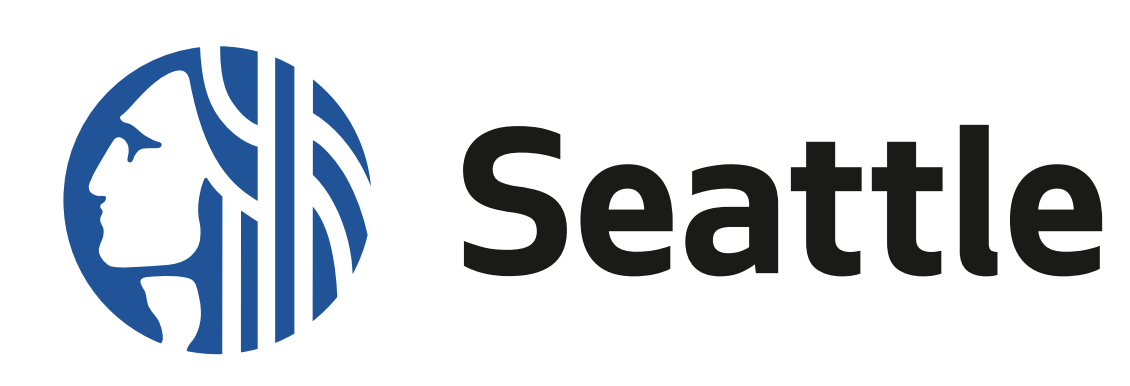

In [ ]:
#GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import Image
Image(filename='/content/drive/MyDrive/Colab Notebooks/P4-Energy&GHG/Seattle.png',width=250, height=100, )

# Project descritption

This project is dedicated to estimate Seattle city buildings annual GHG emission and total energy consumption. In particular, non residential buildings based on 2016 collected data.
This project contains three notebooks as follows:

1.   Assaadi_Yassine_1_notebook_exploratoire_102022: data cleaning, features distribution and transformation, outliers elimination and model subspaces creation.

2.   Assaadi_Yassine_2_notebook_prediction_102022: Concerns GHG emission, it contains models testing, best estimator choice and features effect on the model analysis.

3.   Assaadi_Yassine_3_notebook_prediction_102022: Concerns total energy consumption,it contains as well models testing, best estimator choice and features effect on the model analysis.

Link to data source:
https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Here is a flow chart of all data evolution, from basic cleaning until pre-modeling phase.

In [ ]:
#BASIC LIBs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#STAT TOOLS
from math import sqrt
from scipy import stats #BoxCox
import random
from numpy.lib.function_base import percentile
from pandas.core.algorithms import quantile

#GRAPHS
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

#TRANSFORMATION
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer

from sklearn.decomposition import PCA

#METRICS
from sklearn.metrics import mean_squared_error, r2_score

#DATA SPLITING
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

#IMPUTERS
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

#REGRESSION MODELS
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

#GRIDSEARCH
from sklearn.model_selection import GridSearchCV

#PIPELINES
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

#Columns & rows size
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)


#graphs default configuration
plt.rcParams['figure.figsize']=(10,6)
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_formats = ['svg']

In [ ]:
path= "/content/drive/MyDrive/Colab Notebooks/P4-Energy&GHG/2016_Building_Energy_Benchmarking.csv"

df = pd.read_csv(path,encoding="utf-8")

# 0. Basic data cleaning

In [ ]:
df0 = df.copy()

## 0.1. Missing data count

Text(0, 0.5, '%')

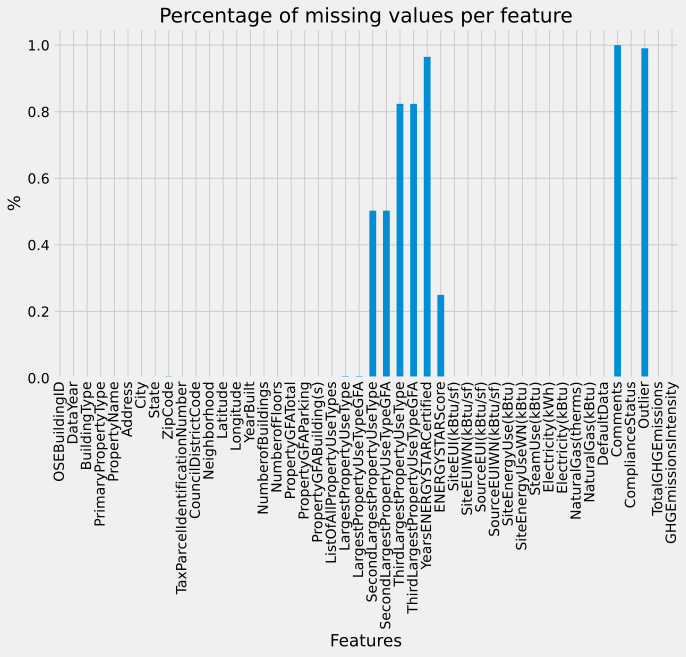

In [ ]:
df0.isna().mean().plot(kind='bar')
plt.title('Percentage of missing values per feature')
plt.xlabel('Features')
plt.ylabel('%')

## 0.2. Deleting >80% missing data variables

In [ ]:
df0 =df0.drop(columns=['ThirdLargestPropertyUseType'
                    ,'ThirdLargestPropertyUseTypeGFA',
                    'YearsENERGYSTARCertified',
                    'Comments',
                    'Outlier'])

## 0.3. Fill with 0/None



In [ ]:
df0['SecondLargestPropertyUseType'].fillna('None', inplace=True)
df0['SecondLargestPropertyUseTypeGFA']=df0['SecondLargestPropertyUseTypeGFA'].fillna(0)

## 0.4. Imputation

In [ ]:
imputer = SimpleImputer (missing_values=np.NaN, strategy = "median")
df0['ENERGYSTARScore'] = imputer.fit_transform(df0[['ENERGYSTARScore']]).ravel() #ravel!

## 0.5. Dropping the rest

In [ ]:
df0.dropna(axis=0, inplace=True)

# 1. Neo-Features by transformation



In [ ]:
df1 = df0.copy()

## 1.1. Steam and Gaz use

In [ ]:
df1['Steam']= df1['SteamUse(kBtu)'].copy()
df1['Gas'] =  df1['NaturalGas(kBtu)'].copy()
df1['Steam'] = df1['Steam'].apply(lambda x: 1 if x>0 else 0)
df1['Gas'] =df1['Gas'].apply(lambda x: 1 if x>0 else 0)

## 1.2. Building Use categories

In [ ]:
df1['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily'],
      dtype=object)

In [ ]:
Commercial1 = { 'Class': 3, 'List' : ['Hotel', 'Restaurant','Other'] }
Residential = {'Class' : 1, 'List' : ['Mid-Rise Multifamily', 'High-Rise Multifamily', 'Residence Hall', 'Low-Rise Multifamily']}
Educational = {'Class' : 4, 'List' : ['K-12 School', 'University']}
Industrial = {'Class' : 6, 'List' : ['Small- and Mid-Sized Office', 'Self-Storage Facility','Warehouse', 'Distribution Center','Laboratory', 'Refrigerated Warehouse']}
Commercial2 = {'Class' : 5, 'List' : ['Large Office','Retail Store','Supermarket / Grocery Store', 'Mixed Use Property']}
Service = {'Class' : 2, 'List' :[ 'Medical Office','Hospital','Worship Facility', 'Senior Care Community']}

BuildingUseList1 = [Commercial1, Residential, Educational, Industrial, Commercial2, Service]

In [ ]:
Residential1 = {'Class' : 1, 'List' : [ 'Residence Hall', 'Low-Rise Multifamily', 'Worship Facility']}

Residential2 = {'Class' : 8, 'List' : ['High-Rise Multifamily', 'Mid-Rise Multifamily']}

Commercial3 = {'Class' : 9, 'List' : ['Large Office', 'Supermarket / Grocery Store']}

Educational = {'Class' : 7, 'List' : ['K-12 School', 'University']}

Commercial2 = {'Class' : 2, 'List' : ['Retail Store', 'Mixed Use Property']}
Commercial1 = { 'Class': 3, 'List' : ['Hotel', 'Restaurant','Other'] }

Industrial1 = {'Class' : 6, 'List' : ['Laboratory', 'Refrigerated Warehouse', 'Distribution Center']}
Industrial2 = {'Class' : 5, 'List' : ['Small- and Mid-Sized Office', 'Self-Storage Facility','Warehouse']}

Service = {'Class' : 4, 'List' :[ 'Medical Office','Hospital', 'Senior Care Community']}

BuildingUseList2 = [Commercial1, Commercial2, Commercial3, Residential1, Residential2, Educational, Industrial1, Industrial2, Service]

In [ ]:
df1['BuildingUse'] = df1['PrimaryPropertyType']

for Type in BuildingUseList2:
  df1['BuildingUse'] = df1['BuildingUse'].apply(lambda x: Type['Class'] if x in Type['List'] else x)

In [ ]:
df1['BuildingUse'].unique()

array([3, 8, 2, 7, 5, 9, 4, 1, 6])

In [ ]:
df1.shape

(3337, 44)

## 1.4. Sensitivity of users and products

In [ ]:
#Health/Labo, Big shops,
HSP_HSC = {'Class': 1, 'List' : [ 'Hospital (General Medical & Surgical)', 'Other/Specialty Hospital', 'Urgent Care/Clinic/Other Outpatient',
                                  'Personal Services (Health/Beauty, Dry Cleaning, etc)', 'Lifestyle Center', 'Laboratory', 'Medical Office',
                                 'Other - Mall', 'Supermarket/Grocery Store', 'Wholesale Club/Supercenter',
                                  'Data Center',

                                 'Police Station', 'Fire Station',]}

HLSP_HLSC = {'Class': 0, 'List' : ['Other - Services',  'Library', 'Pre-school/Daycare',

                                   'Social/Meeting Hall', 'College/University', 'Adult Education', 'Other - Education',
                                   'Fitness Center/Health Club/Gym',
                                   'Movie Theater', 'Museum', 'Restaurant', 'Other - Restaurant/Bar', 'Other - Entertainment/Public Assembly',
                                   'Refrigerated Warehouse',
                                   'Office', 'Financial Office', 'Bank Branch',
                                   'Senior Care Community', 'Repair Services (Vehicle, Shoe, Locksmith, etc)', 'Other - Public Services',
                                   'Food Service', 'Residential Care Facility',
                                   'Other','Parking','Multifamily Housing',
                                  'Performing Arts','Other - Utility',    ]}

LSP_LSC = { 'Class': -1, 'List' : ['Hotel', 'Residence Hall/Dormitory', 'Distribution Center', 'Courthouse',
                                   'Automobile Dealership',
                                   'Manufacturing/Industrial Plant','Other - Recreation',
                                   'Self-Storage Facility','Non-Refrigerated Warehouse','Retail Store',
                                  'Strip Mall', 'Manufacturing/Industrial Plant',
                                    'Other - Lodging/Residential']}

sensitivity = [HSP_HSC, HLSP_HLSC, LSP_LSC]

'Residence Hall/Dormitory'


'Residence Hall/Dormitory'

In [ ]:
df1.groupby('LargestPropertyUseType').median()['SiteEUI(kBtu/sf)'].sort_values(ascending=False)

LargestPropertyUseType
Data Center                                             694.700012
Supermarket/Grocery Store                               245.199997
Urgent Care/Clinic/Other Outpatient                     239.200005
Laboratory                                              218.300003
Hospital (General Medical & Surgical)                   210.900002
Museum                                                  175.600006
Restaurant                                              159.250000
Other/Specialty Hospital                                158.300003
Other - Restaurant/Bar                                  148.199997
Other - Mall                                            145.849997
Police Station                                          136.100006
Lifestyle Center                                        118.700001
Other - Recreation                                      116.000000
Personal Services (Health/Beauty, Dry Cleaning, etc)     96.099998
Wholesale Club/Supercenter             

In [ ]:
df1['Sensitivity'] = np.zeros(len(df1['LargestPropertyUseType']))

for S in sensitivity:
  df1['Sensitivity'] = df1.apply(lambda x: S['Class'] if x['LargestPropertyUseType'] in S['List'] else x['Sensitivity'], axis=1)

df1['Sensitivity'].unique()

array([-1.,  1.,  0.])

## 1.3.  Mergin building use type and its area

In [ ]:
LargestTypeCount = df1['LargestPropertyUseType'].value_counts().sort_values(ascending=False)
SecondTypeCount = df1['SecondLargestPropertyUseType'].value_counts().sort_values(ascending=False)

In [ ]:
TopLargestUse = np.array ([x for x in LargestTypeCount[LargestTypeCount>0].index])
TopLargestUse = np.delete(TopLargestUse, np.where(TopLargestUse=='Other'))
TopSecondUse = np.array ([x for x in SecondTypeCount[SecondTypeCount>0].index])
TopSecondUse = np.delete(TopSecondUse, np.where((TopSecondUse=='Other')|(TopSecondUse=='None')))

In [ ]:
for type1 in TopLargestUse:
  df1["UseType"+'_'+type1] = np.where(df1['LargestPropertyUseType']==type1, df1['LargestPropertyUseTypeGFA']/df1['PropertyGFATotal'], 0)
for type2 in TopSecondUse:
  if type2 in TopLargestUse:
    df1["UseType"+'_'+type2] = df1["UseType"+'_'+type2] + np.where(df1['SecondLargestPropertyUseType']==type2, df1['SecondLargestPropertyUseTypeGFA']/df1['PropertyGFATotal'], 0)
  else:
     df1["UseType"+'_'+type2] = np.where(df1['SecondLargestPropertyUseType']==type2, df1['SecondLargestPropertyUseTypeGFA']/df1['PropertyGFATotal'], 0)

# 2. Features correlation

## 2.1. Correlation map

[Text(0.5, 0, 'OSEBuildingID'),
 Text(2.5, 0, 'ZipCode'),
 Text(4.5, 0, 'Latitude'),
 Text(6.5, 0, 'YearBuilt'),
 Text(8.5, 0, 'NumberofFloors'),
 Text(10.5, 0, 'PropertyGFAParking'),
 Text(12.5, 0, 'LargestPropertyUseTypeGFA'),
 Text(14.5, 0, 'ENERGYSTARScore'),
 Text(16.5, 0, 'SiteEUIWN(kBtu/sf)'),
 Text(18.5, 0, 'SourceEUIWN(kBtu/sf)'),
 Text(20.5, 0, 'SiteEnergyUseWN(kBtu)'),
 Text(22.5, 0, 'Electricity(kWh)'),
 Text(24.5, 0, 'NaturalGas(therms)'),
 Text(26.5, 0, 'DefaultData'),
 Text(28.5, 0, 'GHGEmissionsIntensity'),
 Text(30.5, 0, 'Gas'),
 Text(32.5, 0, 'Sensitivity'),
 Text(34.5, 0, 'UseType_Office'),
 Text(36.5, 0, 'UseType_K-12 School'),
 Text(38.5, 0, 'UseType_Hotel'),
 Text(40.5, 0, 'UseType_Distribution Center'),
 Text(42.5, 0, 'UseType_Supermarket/Grocery Store'),
 Text(44.5, 0, 'UseType_Parking'),
 Text(46.5, 0, 'UseType_College/University'),
 Text(48.5, 0, 'UseType_Other - Recreation'),
 Text(50.5, 0, 'UseType_Laboratory'),
 Text(52.5, 0, 'UseType_Restaurant'),
 Text(54

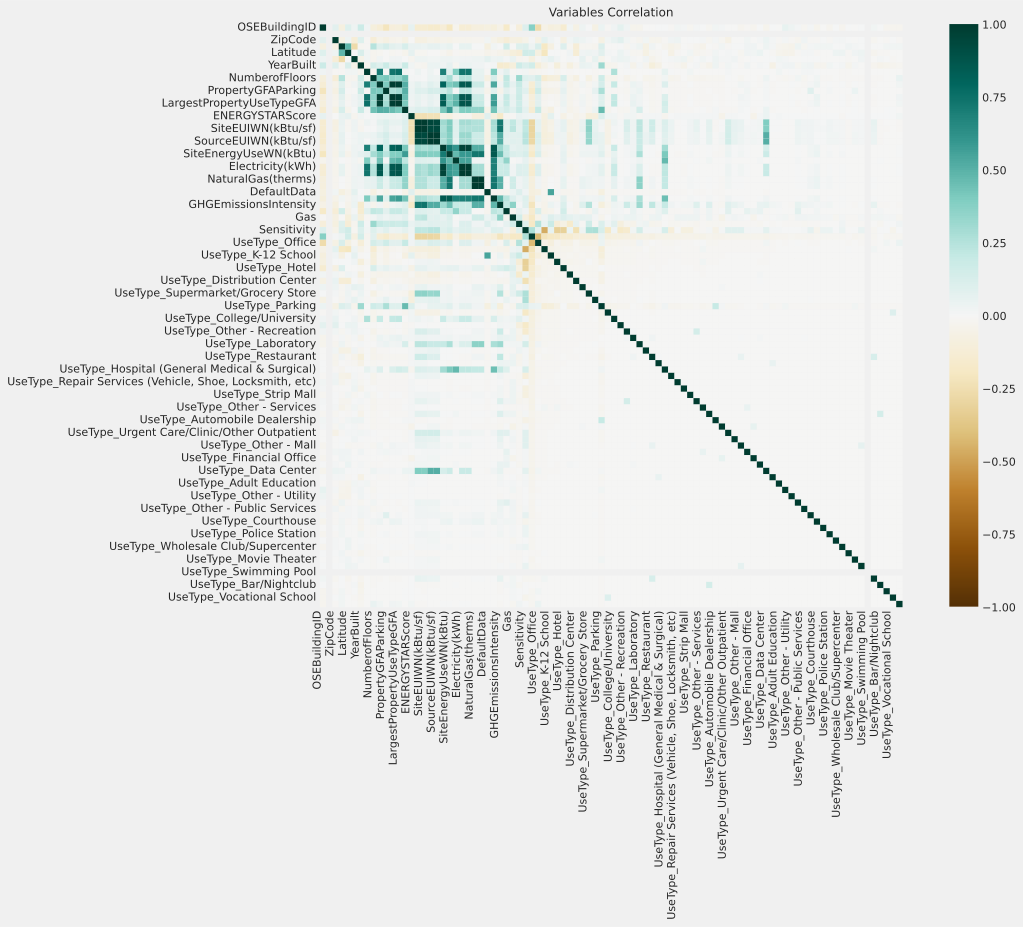

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    df1.corr(),
    vmin=-1, vmax=1, center=0,
    cmap='BrBG',
    square=True,
    annot = False,
    annot_kws={"size": 5})

ax.set_title('Variables Correlation', fontdict={'fontsize':12}, pad=8);

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right')


## 2.2. Elimination of dependent variables (Hight correlation)

In [ ]:
df2=df1.drop(columns = [
    #'BuildingType',
    'PropertyGFABuilding(s)',
    #'PropertyGFATotal',
    'PrimaryPropertyType',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseType',
    'SecondLargestPropertyUseTypeGFA',
    'PropertyGFAParking',

    #Energy parameters= Depend directly on annual energy anaual use
    'SiteEUI(kBtu/sf)',
    'SiteEUIWN(kBtu/sf)',
    'SourceEUI(kBtu/sf)',
    'SourceEUIWN(kBtu/sf)',
    'Electricity(kWh)',
    'Electricity(kBtu)',
    'NaturalGas(therms)',
    'NaturalGas(kBtu)',
    'SiteEnergyUseWN(kBtu)',
    'SteamUse(kBtu)',
    'GHGEmissionsIntensity',

    #'ENERGYSTARScore',

    #'NumberofFloors',
    'NumberofBuildings',

    #Location infos: I kept only Latitude and Longitude
    'Address',
    'State',
    'City',
    'ZipCode',
    'CouncilDistrictCode',
    'Neighborhood',

    #Useless variables:
    'PropertyName',
    'TaxParcelIdentificationNumber',
    'OSEBuildingID',
    'ListOfAllPropertyUseTypes',
    'DefaultData',
    'ComplianceStatus',
    'DataYear'
])

## 2.3. Correlation post elimination



[Text(0.5, 0, 'Latitude'),
 Text(2.5, 0, 'YearBuilt'),
 Text(4.5, 0, 'PropertyGFATotal'),
 Text(6.5, 0, 'SiteEnergyUse(kBtu)'),
 Text(8.5, 0, 'Steam'),
 Text(10.5, 0, 'BuildingUse'),
 Text(12.5, 0, 'UseType_Multifamily Housing'),
 Text(14.5, 0, 'UseType_Non-Refrigerated Warehouse'),
 Text(16.5, 0, 'UseType_Retail Store'),
 Text(18.5, 0, 'UseType_Worship Facility'),
 Text(20.5, 0, 'UseType_Senior Care Community'),
 Text(22.5, 0, 'UseType_Medical Office'),
 Text(24.5, 0, 'UseType_Self-Storage Facility'),
 Text(26.5, 0, 'UseType_Residence Hall/Dormitory'),
 Text(28.5, 0, 'UseType_Other - Entertainment/Public Assembly'),
 Text(30.5, 0, 'UseType_Refrigerated Warehouse'),
 Text(32.5, 0, 'UseType_Social/Meeting Hall'),
 Text(34.5, 0, 'UseType_Manufacturing/Industrial Plant'),
 Text(36.5, 0, 'UseType_Other - Lodging/Residential'),
 Text(38.5, 0, 'UseType_Fitness Center/Health Club/Gym'),
 Text(40.5, 0, 'UseType_Museum'),
 Text(42.5, 0, 'UseType_Bank Branch'),
 Text(44.5, 0, 'UseType_Other/Spec

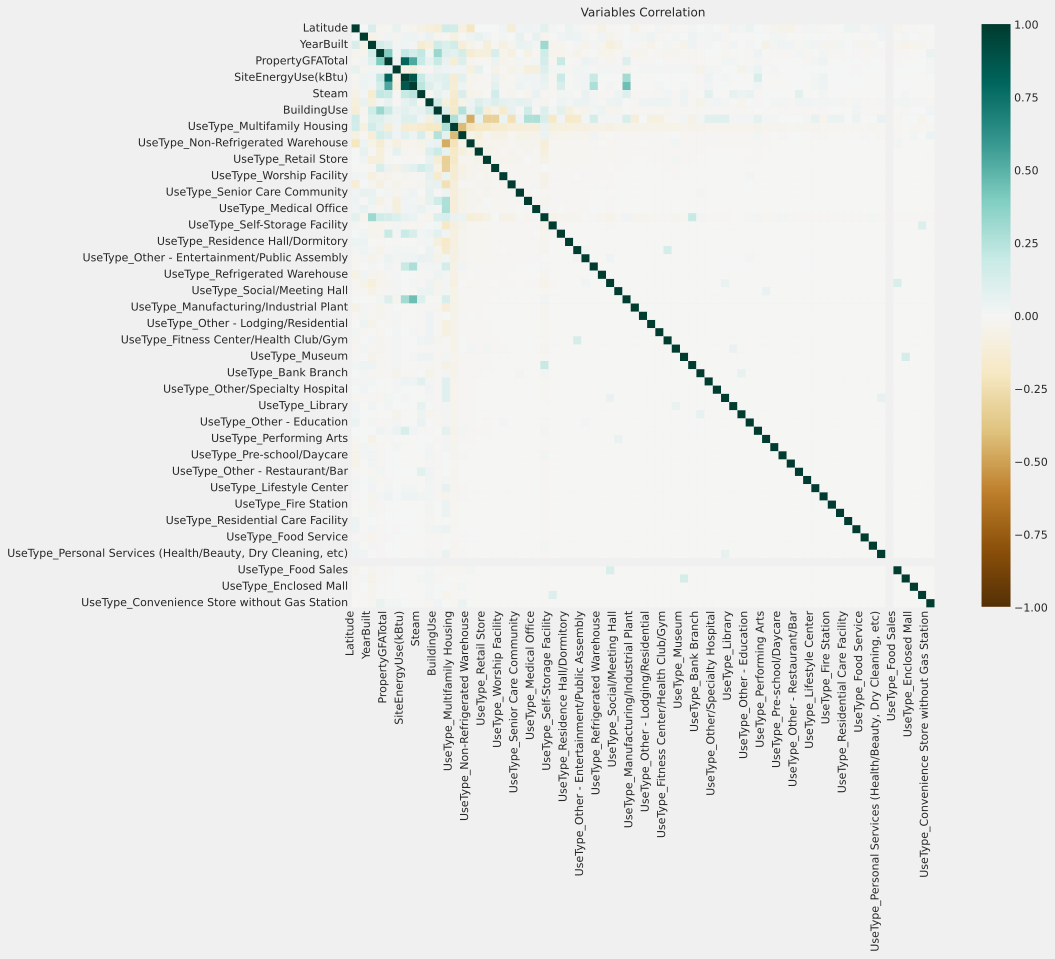

In [ ]:
plt.figure(figsize=(15, 10))

ax = sns.heatmap(
    df2.corr(),
    vmin=-1, vmax=1, center=0,
    cmap='BrBG',
    square=True,
    annot = False,
    annot_kws={"size": 5}
)

ax.set_title('Variables Correlation', fontdict={'fontsize':12}, pad=8);

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
 )

## 2.5. Numerical/Categorical variables

In [ ]:
catg_variables = np.array(df2.loc[:,'UseType_Multifamily Housing':].columns).tolist() + ['Steam','Gas', 'Sensitivity', 'BuildingType']

num_variables = df2.drop(columns = catg_variables).columns
num_variables

Index(['Latitude', 'Longitude', 'YearBuilt', 'NumberofFloors',
       'PropertyGFATotal', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions', 'BuildingUse'],
      dtype='object')

# 3. Distribution of variables

## 3.1. Shape metrics

In [ ]:
def shape_metrics (df, lower_percentile, upper_percentile ):

  Describe = df.describe().T
  Describe =Describe.reset_index().drop(['index','count'], axis=1).round(2)
  skew_ind = df.skew(axis = 0)
  kurt_ind = df.kurt(axis = 0)

  shape_ind = skew_ind.to_frame().reset_index().round(2)
  shape_ind['kurtosis']= kurt_ind.to_frame().reset_index()[0].round(2)
  shape_ind = shape_ind.rename(columns={'index':'variables', 0:'skewness'})
  shape_ind[Describe.columns] = Describe

  Percet_a="Percentile"+str(lower_percentile)
  Percet_b="Percentile"+str(upper_percentile)
  percentile_a=[]
  percentile_b=[]

  for col in df.columns:
    percentile_a.append(np.percentile( df[col], lower_percentile, interpolation = 'midpoint'))
    percentile_b.append(np.percentile( df[col], upper_percentile, interpolation = 'midpoint'))

  shape_ind[Percet_a]= pd.Series(percentile_a)
  shape_ind[Percet_b]= pd.Series(percentile_b)

  return (shape_ind)


## 3.2. Numerical variables distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axe

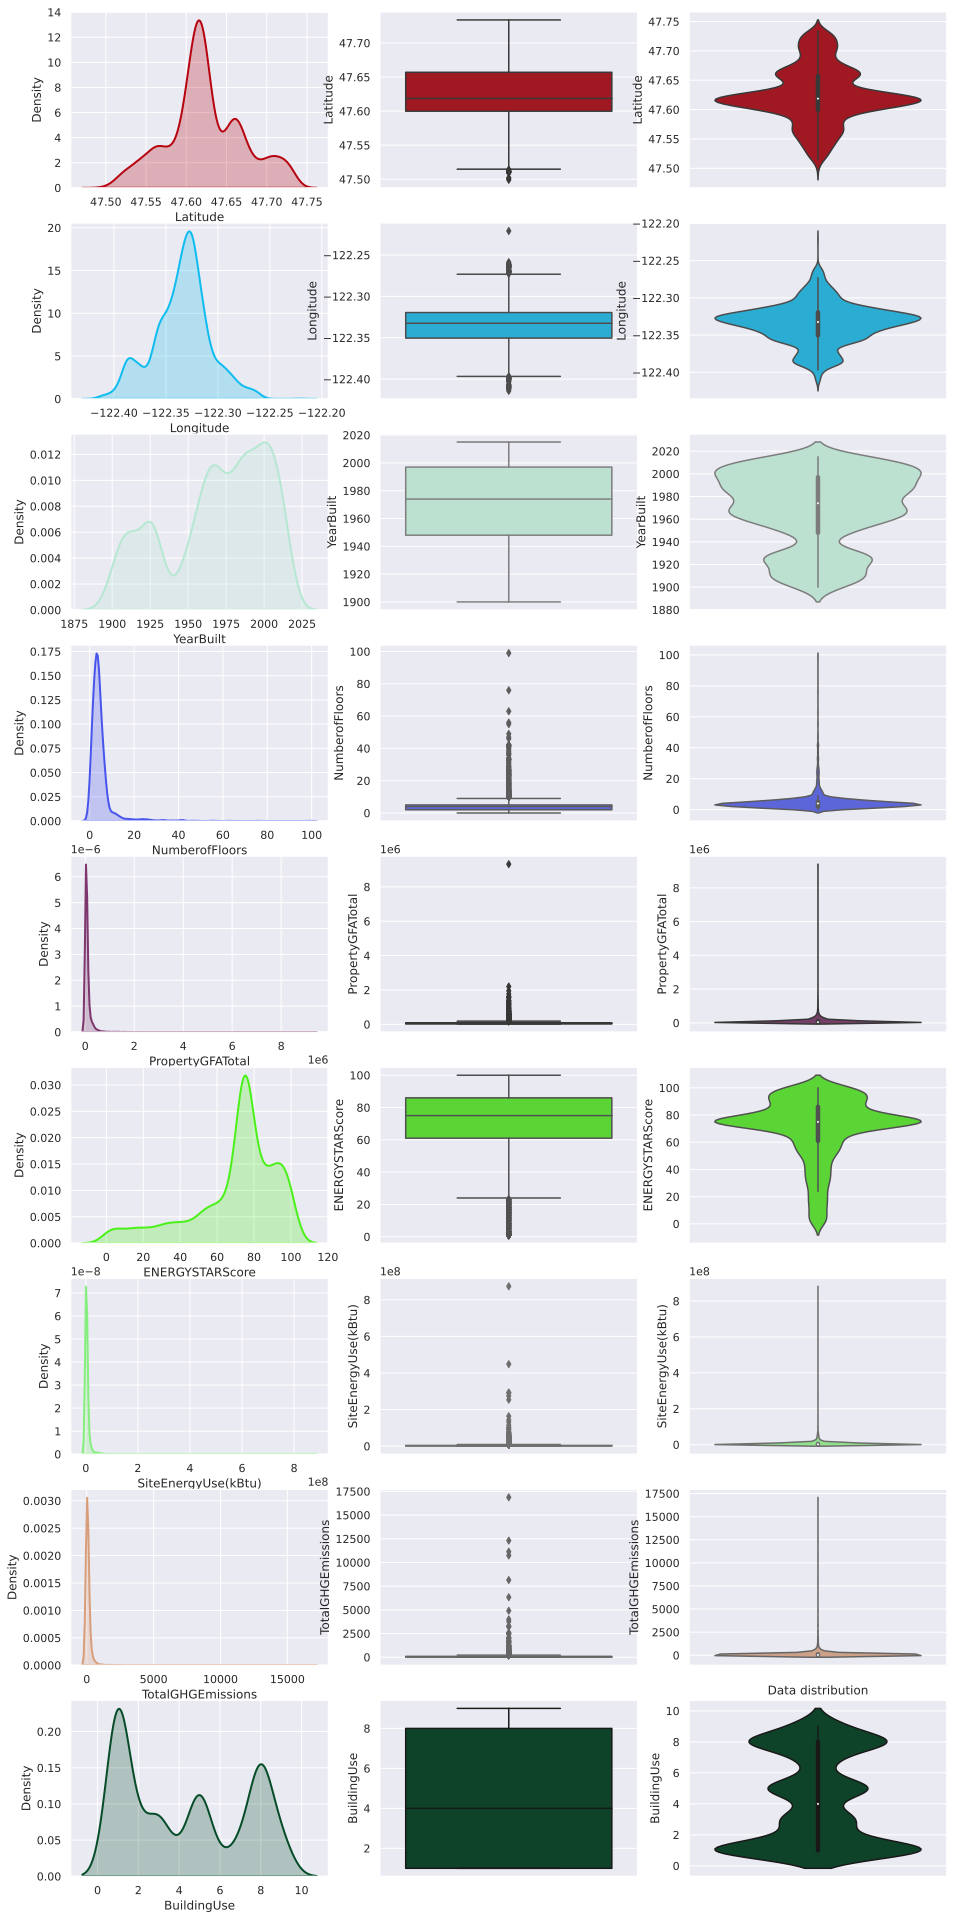

In [ ]:
sns.set(style="darkgrid")

fig, axs = plt.subplots(len(num_variables), 3, figsize=(14,32 ))
i=0

for column in num_variables:
    c=(random.random(), random.random(), random.random())
    sns.distplot(df2[column], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color=c ,axlabel=None, ax=axs[i,0])
    sns.boxplot(y=df2[column], data=df2, color=c, ax=axs[i,1])
    sns.violinplot(y=df2[column], data=df2, color=c,axlabel=None, ax=axs[i,2])
    i=i+1
plt.title(label = 'Data distribution')
plt.show()

# 4. Data transformation

In [ ]:
df31 = df2.copy()

## 4.1.  Negative values

In [ ]:
for column in num_variables:
    if df31[column].min() < 0:
        df31[column] = df31[column] - df31[column].min()

## 4.2. Translation  (Poisitive data)

In [ ]:
for column in num_variables:
    if df31[column].min() == 0.0:
        df31[column] = df31[column] + df31[df31[column]>0][column].min()

0.0 appears as minimum of some variables for scale matters (round = 2)

## 4.3. Logarithm

### 4.3.1. Logarithmic function


In [ ]:
def Log(df):
    for col in df.columns:
      df[col] = df[col].apply(lambda x: np.log(x)) #Running time of apply PAS TERRIBLE

### 4.3.2. DataFrame post logarithm

In [ ]:
df32 = df31.copy()

A = df32.loc[:,['PropertyGFATotal',
                    'SiteEnergyUse(kBtu)',
                    'TotalGHGEmissions',
                    'NumberofFloors',
                    'BuildingUse',
                    'ENERGYSTARScore'
                    ]]

Log(A)

for col in A.columns:
  df32[col] = A[col]

## 4.4. BoxCox transformation

In [ ]:
BoxCox_list = [     'PropertyGFATotal',
                    'SiteEnergyUse(kBtu)',
                    'TotalGHGEmissions',
                    'BuildingUse',
                    'ENERGYSTARScore',
                    'NumberofFloors']


In [ ]:
df33 = df31.copy()
fitted_lmbda= []

for column in BoxCox_list:
    fitted_data, lmbda = stats.boxcox(df33[column])
    df33[column] = fitted_data
    fitted_lmbda.append(lmbda)

fitted_lmbda

[-0.6032594719914243,
 -0.04846471654576564,
 -0.11719038534633844,
 0.26665191655149967,
 1.6842981627393903,
 -0.33509740291436235]

## 4.5. Standard scalering

### 4.4.1. Normalization function

In [ ]:
Normalization = ColumnTransformer([("Normalization", StandardScaler(), num_variables)])

In [ ]:
df34 = df33.copy()

Normalized = pd.DataFrame(Normalization.fit_transform(df34), index= df34.index,   columns= num_variables)


for column in num_variables:
  df34[column] = Normalized[column]

### 4.4.2. BOXPLOTS post normalization


In [ ]:
fig = go.Figure()

for column in num_variables:

    fig.add_trace(go.Box(
        y=df34[column],
        name=column,
        jitter=0.3,
        pointpos=-1.8,
        boxpoints='all',
    ))

fig.update_layout(title= "Post normalization distributions")
fig.show()

## 4.6. Post transformation distribution

### 4.6.1. Distributions graph

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

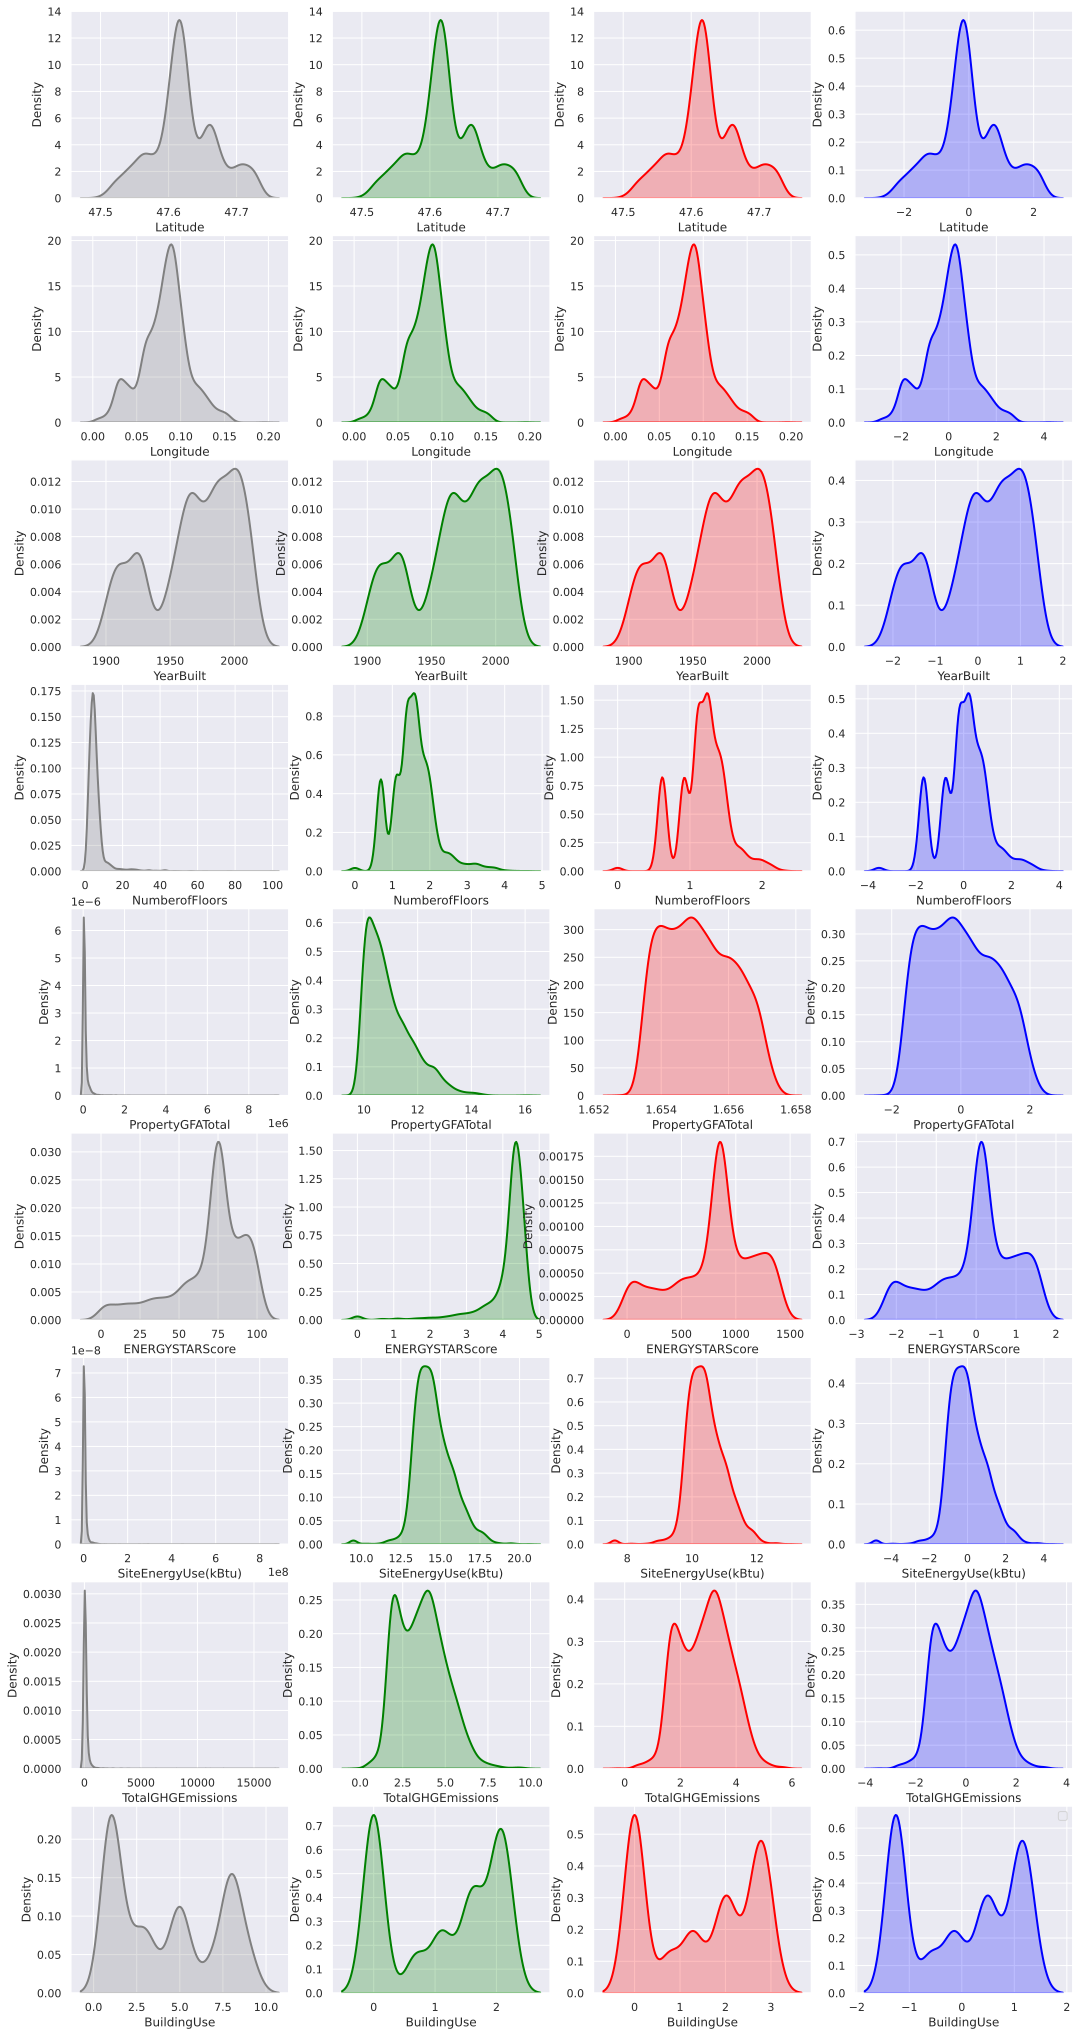

In [ ]:
sns.set(style="darkgrid", )

fig, axs = plt.subplots(len(num_variables), 4, figsize=(16,34 ))
i=0

for column in num_variables:
    sns.distplot(df31[column], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color = 'gray', ax=axs[i,0])
    sns.distplot(df32[column], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color = 'green', ax=axs[i,1])
    sns.distplot(df33[column], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='red', ax=axs[i,2])
    sns.distplot(df34[column], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='blue', ax=axs[i,3])
    i=(i+1)


plt.show()

### 4.6.2. Shape metrics comparaison

In [ ]:
data_shape= shape_metrics (df31.loc[:,num_variables], 1, 99)
data_Log_shape = shape_metrics (df32.loc[:,num_variables], 1, 99)
data_BoxCox_shape = shape_metrics (df33.loc[:,num_variables], 1, 99)
data_normalized_shape = shape_metrics (df34.loc[:,num_variables], 1, 99)

shape_compare = data_shape.loc[:,['variables','skewness']]

shape_compare = shape_compare.rename(columns={'skewness': 'data_skew'})
shape_compare ['Log_skew'] = data_Log_shape['skewness']
shape_compare ['BoxCox_skew'] = data_BoxCox_shape['skewness']
shape_compare ['Normalized_skew'] = data_normalized_shape['skewness']

shape_compare

variables  data_skew  Log_skew  BoxCox_skew  Normalized_skew
0             Latitude       0.14      0.14         0.14             0.14
1            Longitude      -0.14     -0.14        -0.14            -0.14
2            YearBuilt      -0.54     -0.54        -0.54            -0.54
3       NumberofFloors       5.92      0.84        -0.05            -0.05
4     PropertyGFATotal      24.35      1.16         0.20             0.20
5      ENERGYSTARScore      -1.18     -3.50        -0.54            -0.54
6  SiteEnergyUse(kBtu)      24.73      0.31        -0.04            -0.04
7    TotalGHGEmissions      19.40      0.42         0.03             0.03
8          BuildingUse       0.24     -0.25        -0.13            -0.13

# 5. Outliers

### 5.1. OUTLIERS elimination

In [ ]:
upper_lim=0.75
lower_lim=0.25

def Outliers_Cleaner(df, lower_lim, upper_lim, num_variables):

    for col in num_variables:
      Q1 = df[col].quantile(lower_lim)
      Q3 = df[col].quantile(upper_lim)
      IQR = Q3 - Q1
      df = df[ (df[col] <= (Q3 + 1.5*IQR)) & (df[col] >= (Q1 - 1.5*IQR)) ]

    print(f'data cleaned shape: {df.shape}')
    return df


In [ ]:
df4=df34.copy()
df4 = Outliers_Cleaner(df4, lower_lim, upper_lim, num_variables)

data cleaned shape: (3101, 72)


## 5.2. Distribution post outliers elimination

In [ ]:
fig = go.Figure()

for column in num_variables:

    fig.add_trace(go.Box(
        y=df4[column],
        name=column,
        jitter=0.3,
        pointpos=-1.8,
        boxpoints='all',

    ))

fig.update_layout(title= "Post outliers elimination distributions")
fig.show()

# 6. Subspaces



## 6.1. KNN Imputer for ENERGYSTARScore

In [ ]:
def df_KNN_ENERGYSTARScore(Knn, DF):

  #Variable imputation
  KNN_imp = KNNImputer(n_neighbors = Knn)
  X= DF.loc[:, DF.columns !='ENERGYSTARScore']
  A = KNN_imp.fit_transform(X)
  DF = pd.DataFrame(A, index=DF.index, columns= X.columns)

  #Skewness
  B, lmbda = stats.boxcox(DF['ENERGYSTARScore_KNN'])
  DF['ENERGYSTARScore_KNN'] = B
  print(lmbda)

  #StandardScalering
  scaler = StandardScaler()
  C = scaler.fit_transform(DF[['ENERGYSTARScore_KNN']].values)
  #D = pd.DataFrame(C, index=DF.index, columns= ['ENERGYSTARScore_KNN'] )
  #DF['ENERGYSTARScore_KNN'] = D['ENERGYSTARScore_KNN']

  return C


In [ ]:
df5= df4.copy()
df5['ENERGYSTARScore_KNN']= df['ENERGYSTARScore']

num_variables0 = np.append(num_variables, 'ENERGYSTARScore_KNN')
df5['ENERGYSTARScore_knn1'] = df_KNN_ENERGYSTARScore(1, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn2'] = df_KNN_ENERGYSTARScore(2, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn5'] = df_KNN_ENERGYSTARScore(5, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn6'] = df_KNN_ENERGYSTARScore(6, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn7'] = df_KNN_ENERGYSTARScore(7, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn8'] = df_KNN_ENERGYSTARScore(8, df5.loc[:,num_variables0 ])
df5['ENERGYSTARScore_knn10'] = df_KNN_ENERGYSTARScore(10, df5.loc[:,num_variables0 ])

df5 = df5.rename(columns={'ENERGYSTARScore': 'ENERGYSTARScore_Median'})
df5 = df5.drop('ENERGYSTARScore_KNN', axis=1)

for column in catg_variables:
  df5[column] = df4[column]

1.334494183501395
1.3928182213231628
1.4019066833959768
1.4044426030983879
1.4047179779497718
1.4103875403449957
1.4149729149501844


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

/usr/local/lib/python3

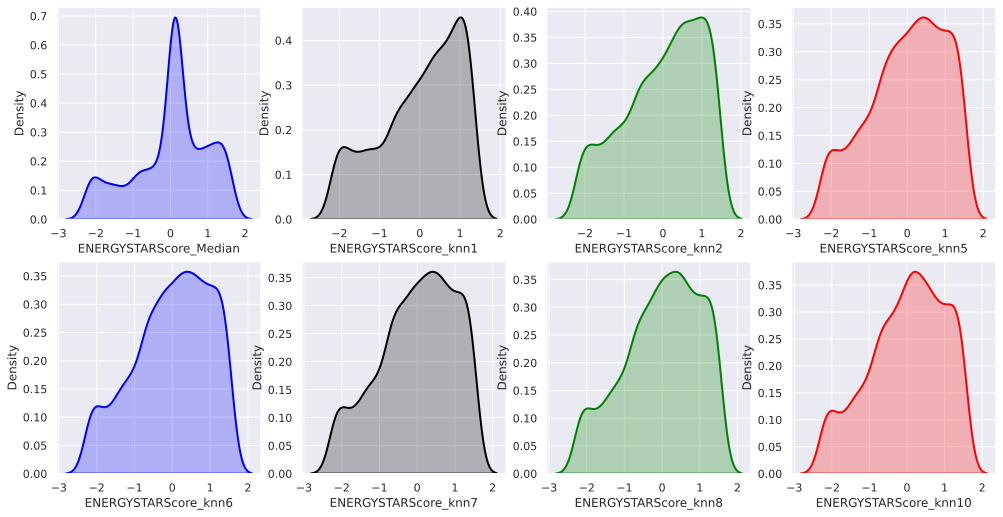

In [ ]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 4, figsize=(15,8))

#ENERGYSTARScore with simple imputer = median
sns.distplot(df5['ENERGYSTARScore_Median'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='blue', ax=axs[0,0])
#ENERGYSTARScore with knn=1
sns.distplot(df5['ENERGYSTARScore_knn1'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='black', ax=axs[0,1])
#ENERGYSTARScore with knn=2
sns.distplot(df5['ENERGYSTARScore_knn2'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='green', ax=axs[0,2])
#ENERGYSTARScore with knn=5
sns.distplot(df5['ENERGYSTARScore_knn5'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='red', ax=axs[0,3])
#ENERGYSTARScore with knn=6
sns.distplot(df5['ENERGYSTARScore_knn6'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='blue', ax=axs[1,0])
#ENERGYSTARScore with knn=7
sns.distplot(df5['ENERGYSTARScore_knn7'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='black', ax=axs[1,1])
#ENERGYSTARScore with knn=8
sns.distplot(df5['ENERGYSTARScore_knn8'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='green', ax=axs[1,2])
#ENERGYSTARScore with knn=10
sns.distplot(df5['ENERGYSTARScore_knn10'], hist = False, kde=True, kde_kws = {'shade': True, 'linewidth': 2}, color='red', ax=axs[1,3])

## 6.2. Pipeline column transformer

In [ ]:
#DataTransform = ColumnTransformer([
#                 ("Normalization", StandardScaler(), num_variables)
#                 ,("One_Hot_Encoder", OneHotEncoder(), catg_variables)]
#                 , remainder = 'passthrough'
#                  )

In [ ]:
#x = pd.DataFrame(X.todense(), columns= columns_tranformed)
#x1= DataTransform.fit_transform(df4)

#catg_variables_encoded = DataTransform.transformers_[1][1].get_feature_names(catg_variables)
#columns_tranformed = np.append(num_variables, catg_variables_encoded)

## 6.3. Data preparation recap

In [ ]:
DFs = ['df', 'df0', 'df1', 'df2', 'df31', 'df32', 'df33', 'df34', 'df4', 'df5' ]
Shapes = [df.shape ,df0.shape, df1.shape, df2.shape, df31.shape, df32.shape, df33.shape, df34.shape, df4.shape, df5.shape ]
Data_status = ['Untreated', 'NAN cleaned', 'New features added', 'Features selected',  'Positive values', 'Logarithm Transformation', 'BoxCox Transformation', 'Normalized data', 'Outliers eliminated', 'Model Features selection' ]

In [ ]:
Dfs = pd.DataFrame({'data': DFs, 'Size': Shapes, 'Description': Data_status})
Dfs

data         Size               Description
0    df   (3376, 46)                 Untreated
1   df0   (3337, 41)               NAN cleaned
2   df1  (3337, 104)        New features added
3   df2   (3337, 72)         Features selected
4  df31   (3337, 72)           Positive values
5  df32   (3337, 72)  Logarithm Transformation
6  df33   (3337, 72)     BoxCox Transformation
7  df34   (3337, 72)           Normalized data
8   df4   (3101, 72)       Outliers eliminated
9   df5   (3101, 79)  Model Features selection

## 6.4. Save prepared data to csv file

In [ ]:
Path = '/content/drive/MyDrive/Colab Notebooks/P4-Energy&GHG/P4-Prepared_Data.csv'

df5.to_csv(path_or_buf = Path, index_label = 'index')